# Analyse and Explore the Climate Data (SQL Alchemy)
---
## Step #0 - Import Dependencies and Setup

In [1]:
# Specify Matplotlib to display matplotlib plots in the output cell
# From Matplotlib, use the 'fivethirtyeight' visual style of plotting
# Pyplot function from Matplotlib to draw plots
# Pandas Library for storing data into DataFrame objects (used in tandem with Matplotlib)
# DateTime Library for formatting and calculating date

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

## Step #1 - Jupyter Notebook Database Connection (Using `SQLAlchemy` Library)
---
### Import `SQLAlchemy` & Relevant Classes

In [2]:
# Python SQL toolkit and Object Relational Mapper (sqlalchemy)
# Used to auto reflect database and generate ORM classes (automap_base)
# Used to establish SQLAlchemy Session to query from DB (Session)
# Relevant functions explained further into the code... (create_engine / func / inspect / and_ / desc)

import sqlalchemy                                                  
from sqlalchemy.ext.automap import automap_base                    
from sqlalchemy.orm import Session                                 
from sqlalchemy import create_engine, func, inspect, and_, desc     

### Define Connection to SQLite Database

In [3]:
# Define connection to hawaii.sqlite file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

### Reflect Tables from SQLite Database into ORM Classes

In [4]:
# Reflect Database and generate ORM classes based on the SQLite tables
# Show all tables (ORM Classes) from the database
Base = automap_base()
Base.prepare(autoload_with = engine)
Base.classes.keys()

['measurement', 'station']

### Save References for ORM Classes

In [5]:
# Reference to the 'measurement' ORM Class of the SQLite Database
measurement = Base.classes.measurement

# Reference to the 'station' ORM Class of the SQLite Database
station = Base.classes.station

## Step 2 - Precipitation Analysis
---
### Establish `SQLAlchemy` Session (Link Python to SQLite Database)

In [6]:
# Create a database session object to establish a new session with the SQLite Database
session = Session(engine)

### Inspect `measurement` SQLite Table

In [7]:
 # Using the inspector function to print the column names within the 'measurement' table and its types
inspector = inspect(engine)    
measurement_columns = inspector.get_columns('measurement')

# For every column in the list of 'measurement' table columns, print the column name and type
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
 # Query the first 10 date datapoints to preview how the data is formatted (YYYY-MM-DD)
first_10 = session.query(measurement.date).limit(10).all()

first_10

[('2010-01-01',),
 ('2010-01-02',),
 ('2010-01-03',),
 ('2010-01-04',),
 ('2010-01-06',),
 ('2010-01-07',),
 ('2010-01-08',),
 ('2010-01-09',),
 ('2010-01-10',),
 ('2010-01-11',)]

### `SQLAlchemy` Query #1 - Get Most Recent Date from `measurement` SQLite Table

In [9]:
# Using 'func', query the maximum date from 'measurement' and return the first result (using scalar())
recent_date = session.query(func.max(measurement.date)).scalar()

# Convert the date string to datetime object; used to get the date 12 months prior from recent date
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')

# Print the 'Recent Date' value and its object type
print("Recent Date:", recent_date)
print(type(recent_date))

Recent Date: 2017-08-23 00:00:00
<class 'datetime.datetime'>


### `SQLAlchemy` Query #2 - Get Previous 12 Months of Precipitation Data from `measurement` SQLite Table

In [10]:
# Using 'timedelta' from the DateTime Library, calculate the difference between the recent date and 365 days
start_date = recent_date - dt.timedelta(days = 365)

# Print the 'Start Date' value and its object type
print("Start Date:", start_date)
print(type(start_date))

Start Date: 2016-08-23 00:00:00
<class 'datetime.datetime'>


In [11]:
# Pre-define the columns from 'measurement' used for the upcoming query... 
date_prcp_columns = [func.date(measurement.date), measurement.prcp]

# Convert the Start & Recent dates back into string in YYYY-MM-DD format
start_date = dt.datetime.strftime(start_date, '%Y-%m-%d')
recent_date = dt.datetime.strftime(recent_date, '%Y-%m-%d')

# Query all date and prcp elements from 'measurement' where...
# The date is greater than or equal to 2016-08-23 AND the date is less than or equal to 2017-08-23 
# '_and' function used to combine multiple conditionals within a single filter in the same query
# *date_prcp_columns is to unpack the columns from the list in sequence using the '*' operator
prcp_12_months = session.query(*date_prcp_columns).filter(
    and_(
        func.date(measurement.date) >= start_date,
        func.date(measurement.date) <= recent_date
    )
).all()

### Load `SQLAlchemy` Query #2 Results into Pandas DataFrame as `prcp_df` (Sorted by Date)

In [12]:
# Pre-define the column names for the upcoming Pandas DataFrame
prcp_column_names = ["date", "prcp"]

# From the query of precipitation data from the previous 12 months...
# Store them in a new DataFrame
prcp_df = pd.DataFrame(prcp_12_months, columns = prcp_column_names)

# Drop rows with NaN values in the DataFrame
prcp_df = prcp_df.dropna()

# Using Pandas' 'to_datetime' function, convert all date elements as datetime in the format YYYY-MM-DD
prcp_df["date"] = pd.to_datetime(prcp_df["date"], format = "%Y-%m-%d")

# Sort the DataFrame by 'date' and reset the index
prcp_df = prcp_df.sort_values(by = "date").reset_index(drop = True)

# Show the Precipitation DataFrame
prcp_df

,date,prcp
0,2016-08-23,0.0
1,2016-08-23,0.5
2,2016-08-23,1.3
3,2016-08-23,17.8
4,2016-08-23,3.8
...,...,...
2016,2017-08-22,12.7
2017,2017-08-23,0.0
2018,2017-08-23,2.0
2019,2017-08-23,0.0


### Plot `prcp_df` DataFrame as Plot (Using Matplotlib)

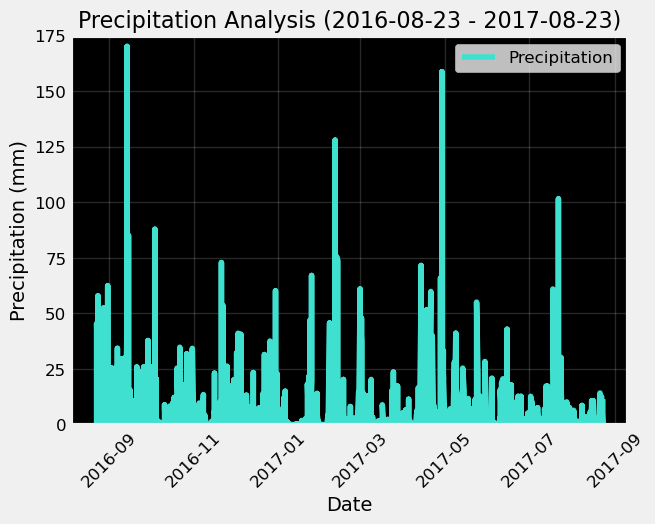

In [13]:
# Get the min and max dates from the Precipitation DataFrame
prcp_min_date = prcp_df["date"].dt.date.min()
prcp_max_date = prcp_df["date"].dt.date.max()


# Using the Matplotlib library (plt), generate a plot where...
# The 'x' axis is the 'Date' Type; the 'y' axis is the 'Percipiatation (mm)';
# Colour of the bars are Turquoise; bar outlines are coloured white and set w/ a line thickness of 2
plt_plot = plt.plot(prcp_df["date"],
                      prcp_df["prcp"],
                      color = "turquoise")

# In the plot, set a new title where Font Size is 16
plt.title(f"Precipitation Analysis ({prcp_min_date} - {prcp_max_date})", fontsize = 16)

# In the plot, set a new label for the 'x' axis where Font Size is 14
plt.xlabel("Date", fontsize = 14)

# In the plot, set a new label for the 'y' axis where Font Size is 14
plt.ylabel("Precipitation (mm)", fontsize = 14)

# In the plot, rotate the 'x' ticks 45 degrees clockwise and adjust Font size to 12
plt.xticks(rotation = 45, fontsize = 12)

# In the plot, update the 'y' axis range as: 0 to 175
plt.ylim(0, 175)

# In the plot, adjust 'y' tick Font size to 12
plt.yticks(range(0, 176, 25), fontsize = 12)

# Set the background color of the plot (within the axes) to Black
plt.gca().set_facecolor("black")

# Add grid lines (faint) to the plot
plt.grid(alpha = 0.2)

# In the plot, add a 'Legend';
    # Position it on the upper right of the figure plot
    # adjust font size in the Legend to 12
plt.legend(["Precipitation"], loc = "upper right", fontsize = 12)

# Display the Plot (Using Matplotlib)
plt.show()

### Print Summary Stats for 'Precipitation' from `prcp_df` (Using Pandas)

In [14]:
# Use the describe() method to get summary statistics for Precipitation and store in a new DataFrame
prcp_summary_stats = pd.DataFrame(prcp_df["prcp"].describe())

# Show the Summary Stats for Precipitations
prcp_summary_stats

,prcp
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


## Step #3 - Station Analysis
---
### Inspect `station` SQLite Table

In [15]:
# Using the inspector function to print the column names within the 'station' table and its types
station_columns = inspector.get_columns('station')

# For every column in the list of 'station' table columns, print the column name and type
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### `SQLAlchemy` Query #3 - Calculate the Total Number of Stations from `station` SQLite Table

In [16]:
# Query the count of all rows in the 'station' table (Total Number of Stations)
total_stations = session.query(station).count()

# Print the value
print("Total No. Stations:", total_stations)

Total No. Stations: 9


### `SQLAlchemy` Query #4 - Find the 'Most-Active Stations' using `station` & `measurement` SQLite Tables

In [17]:
# Query all stations from 'station' and...
# the result count of observations a station has been listed where...
# the 'station' column from both the 'measurement' & 'station' tables match i.e. common link between 2 tables
# In addition, group the queried data by 'station' from the 'station' table and...
# Sort the queried data in descending order of the result count of observations (using the 'desc' function)
active_stations = session.query(station.station, func.count().label('observation_count')).join(
    measurement,
    station.station == measurement.station
).group_by(measurement.station).order_by(desc('observation_count')).all()


# Show the queried data
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### `SQLAlchemy` Query #5 - Min/Max/Avg Temperature for the 'Most-Active Station' using `measurement` SQLite Table

In [18]:
# Get the 'Most Active' Station from the previous queried data (first listed since it is already sorted in desc)
most_active_station = active_stations[0].station

print(f"Most Active Station: {most_active_station}")

Most Active Station: USC00519281


In [19]:
# Query the min, max and mean of the temperature (tobs) from 'measurement' where...
# station is the most active station
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()

temperature_stats

[(12.2, 29.4, 22.03582251082252)]

### `SQLAlchemy` Query #6 - Get Previous 12 Months of Temperature Data for the 'Most-Active Station'

In [20]:
# Pre-define the columns to use for the upcoming query
date_tobs_columns = [func.date(measurement.date), measurement.tobs]

# Query all dates and tobs values from 'measurement' where...
# station is the most active station and where...
# The date is greater than or equal to 2016-08-23 AND the date is less than or equal to 2017-08-23 
# '_and' function used to combine multiple conditionals within a single filter in the same query
# *date_tobs_columns is to unpack the columns from the list in sequence using the '*' operator
tobs_12_months = session.query(*date_tobs_columns).filter(measurement.station == most_active_station).filter(
    and_(
        func.date(measurement.date) >= start_date,
        func.date(measurement.date) <= recent_date
    )
).all()

### Load `SQLAlchemy` Query #6 Results into Pandas DataFrame as `tobs_df`

In [21]:
# Pre-define the column names for the upcoming Pandas DataFrame
tobs_column_names = ["date", "tobs"]

# Store the 12 months worth of queried temperature data into a new DataFrame
tobs_df = pd.DataFrame(tobs_12_months, columns = tobs_column_names)

# Drop any row from the DataFrame with NaN values
tobs_df = tobs_df.dropna()

# Display the Temperature DataFrame
tobs_df

,date,tobs
0,2016-08-23,25.0
1,2016-08-24,25.0
2,2016-08-25,26.7
3,2016-08-26,26.7
4,2016-08-27,23.9
...,...,...
347,2017-08-14,25.0
348,2017-08-15,25.0
349,2017-08-16,24.4
350,2017-08-17,24.4


### Plot `tobs_df` DataFrame as Histogram w/ 12 Bins (Using Matplotlib)

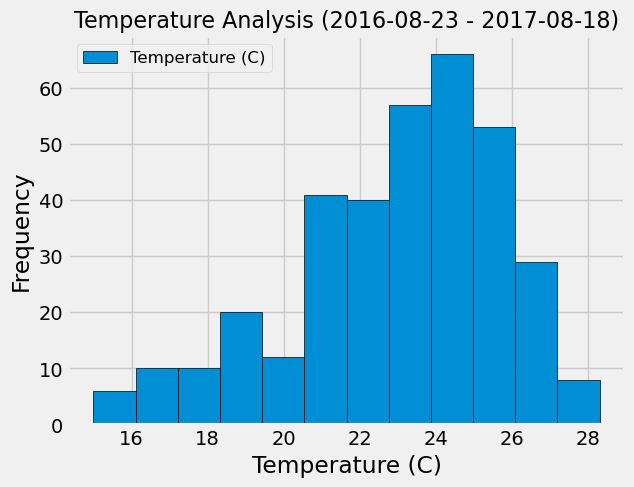

In [22]:
# Get the min and max dates from the Precipitation DataFrame
tobs_min_date = tobs_df["date"].min()
tobs_max_date = tobs_df["date"].max()


# Create a histogram with 12 bins using the Temperature data only from the DataFrame
# This makes the x axis as the temperature, the y axis as the frequency
plt.hist(tobs_df["tobs"], bins = 12, edgecolor = 'black')

# Set x/y labels and title
plt.xlabel('Temperature (C)')
plt.ylabel('Frequency')
plt.title(f"Temperature Analysis ({tobs_min_date} - {tobs_max_date})", fontsize = 16)

# In the plot, add a 'Legend';
# Position it on the upper left of the histogram plot
# adjust font size in the Legend to 12
plt.legend(["Temperature (C)"], loc = "upper left", fontsize = 12)

# Show the His
plt.show()

### [Bonus] Print Summary Stats for 'Temperature' from `tobs_df` (Using Pandas)

In [23]:
# Use the describe() method to get summary statistics for the Temperature
tobs_summary_stats = pd.DataFrame(tobs_df["tobs"].describe())

# Log the summary statistics for Temperature
tobs_summary_stats

,tobs
count,352.000000
mean,22.835511
std,2.629856
min,15.000000
25%,21.100000
50%,23.300000
75%,25.000000
max,28.300000


### Terminate `SQLAlchemy` Session

In [24]:
session.close()